In [1]:
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib import Lowpass, DoubleExp

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time

import neuron

In [62]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA
        neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
        neuron.h.load_file('stdrun.hoc')

    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        J_steps = 30
        max_rate = max_rates.max()
        J_threshold = None
        J_max = None
        Jr = 1e-9  # test currents in amps
        for _ in range(10):
            J_test = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J_test, np.ones(J_steps), np.zeros(J_steps))
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J_test[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J_test[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")
        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
#         print('max_rates', max_rates)
#         print('intercepts', intercepts)
#         print('gain', gain)
#         print('bias', bias)
            
#         xs = np.linspace(-1, 1, 20)
#         rates = np.zeros((max_rates.shape[0], xs.shape[0]))
#         for n in range(max_rates.shape[0]):
#             gain_n = np.ones_like(xs)*gain[n]
#             bias_n = np.ones_like(xs)*bias[n]
#             rates_n = self.rates(xs, gain_n, bias_n)
#             rates[n] = rates_n
#         fig, ax = plt.subplots()
#         ax.plot(xs, rates.T)
#         plt.show()

        return gain, bias
    
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
#         print("Estimating firing rates in response to patch clamp...")
        J_test = self.current(x, gain, bias)
        n_neurons = gain.shape[0]
        spike_counts = np.zeros((n_neurons))
        settle_time = 0.1
        sim_time = 1.0
        dt = 0.001  # dt_nengo
        neuron.h.dt = self.dt_neuron
        neurons = []
        spk_vecs = []
        spk_recs = []
        soma_stims = []
        basal_stims = []
        prox_stims = []
        dist_stims = []
        for n in range(n_neurons):
            neurons.append(neuron.h.Durstewitz())
            # build morphology, but assume non-DA condition for calculating gain/bias
            neurons[n].init()
            spk_vecs.append(neuron.h.Vector())
            spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
            spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
#             soma_stims.append(neuron.h.IClamp(neurons[n].soma(0.5)))
#             soma_stims[n].dur = (settle_time+sim_time)*1000
#             soma_stims[n].amp = J_test[n]*1e9
            basal_stims.append(neuron.h.IClamp(neurons[n].basal(0.5)))
            basal_stims[n].dur = (settle_time+sim_time)*1000
            basal_stims[n].amp = J_test[n]*1e9  # convert amps to nanoamps
            prox_stims.append(neuron.h.IClamp(neurons[n].prox(0.5)))
            prox_stims[n].dur = (settle_time+sim_time)*1000
            prox_stims[n].amp = J_test[n]*1e9  # convert amps to nanoamps
            dist_stims.append(neuron.h.IClamp(neurons[n].dist(0.5)))
            dist_stims[n].dur = (settle_time+sim_time)*1000
            dist_stims[n].amp = J_test[n]*1e9  # convert amps to nanoamps
        neuron.h.tstop = (settle_time+sim_time)*1000
        neuron.h.run()
        spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
        for n in range(n_neurons):
            spk_vecs[n].play_remove()
            del(neurons[0])
#         print('J', J_test)
#         print('Firing Rate', np.array(spike_counts)/sim_time)
        return np.array(spike_counts)/sim_time
    
    def step_math(self, J, stims, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = J.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        for n in range(n_neurons):
            for stim in stims:
                stim[n].amp = J[n]*1e9
        if neuron.h.t < (time - dt)*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        voltage[:] = np.array([v[-1] for v in v_recs])  # .clip(-100, 60)
        assert np.isfinite(voltage).all()
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        # check if neurons have spent more than 10% of time in bad voltage range over last 100 ms
        for v in v_recs:
            if len(v) > 100:
                volts_above = np.where(np.array(v)[-100:] > -20)[0]
                volts_below = np.where(np.array(v)[-100:] < -10)[0]
                volts_bad = np.intersect1d(volts_above, volts_below)
                ratio = len(volts_bad) / 100
                if ratio > 0.1:
                    warnings.warn('neuron %s is oversaturated'%n)
        

class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
#         self.t_recs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(len(neurons))]
        self.soma_stims = []
        self.basal_stims = []
        self.prox_stims = []
        self.dist_stims = []
#         import ipdb
#         ipdb.set_trace()
        for n in range(len(neurons)):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
#             self.t_recs.append(neuron.h.Vector())
#             self.t_recs[n].record(neuron.h._ref_t)
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
#             self.soma_stims.append(neuron.h.IClamp(self.neurons[n].soma(0.5)))
#             self.soma_stims[n].dur = 100*1000
#             self.soma_stims[n].amp = 0
            self.basal_stims.append(neuron.h.IClamp(self.neurons[n].basal(0.5)))
            self.basal_stims[n].dur = 100*1000
            self.basal_stims[n].amp = 0
            self.prox_stims.append(neuron.h.IClamp(self.neurons[n].prox(0.5)))
            self.prox_stims[n].dur = 100*1000
            self.prox_stims[n].amp = 0
            self.dist_stims.append(neuron.h.IClamp(self.neurons[n].dist(0.5)))
            self.dist_stims[n].dur = 100*1000
            self.dist_stims[n].amp = 0
#         self.stims = [self.soma_stims]
        self.stims = [self.basal_stims, self.prox_stims, self.dist_stims]
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
#         neuron.h.init()

    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                J, self.stims, self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before,
                voltage, output, time, dt)
        return step_nrn

    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]
    
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    cells = [neuron.h.Durstewitz() for n in range(neurons.size_in)]
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        neurons=cells,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = cells
    model.add_op(neuronop)


class TransmitSpikes(Operator):
    def __init__(self, neurons, synapses, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.synapses = synapses
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = self.weights[pre, post]
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    self.netcons[pre, post].append(nc)
            
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = (time.item()-dt)*1000
            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step

    @property
    def spikes(self):
        return self.reads[0]


@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):

        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"

        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        neurons = model.params[conn.post_obj.neurons]
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        enc = model.params[conn.post_obj].scaled_encoders.T[conn.post_slice]
        weights = np.dot(d.T, enc) * 1e9  # convert amps to nanoamps

        taus = -1.0/np.array(conn.synapse.poles)
        synapses = np.zeros((weights.shape), dtype=list)
        E_exc = 0.0  # reversal potential for excitatory synapses in mV
        E_inh = -70.0  # reversal potential for inhibitory synapses in mV
#         ts = np.arange(0, 1, 0.001)

        for pre in range(synapses.shape[0]):
            for post in range(synapses.shape[1]):
                if len(taus) == 1:
#                     syn_soma = neuron.h.ExpSyn(neurons[post].soma(0.5))
#                     syn_soma.tau = taus[0]*1000
                    syn_basal = neuron.h.ExpSyn(neurons[post].basal(0.5))
                    syn_basal.tau = taus[0]*1000
                    syn_prox = neuron.h.ExpSyn(neurons[post].prox(0.5))
                    syn_prox.tau = taus[0]*1000
                    syn_dist = neuron.h.ExpSyn(neurons[post].dist(0.5))
                    syn_dist.tau = taus[0]*1000
                    k = taus[0]
#                     norm = np.sum(1.0/taus[0]*np.exp(-ts/taus[0]))
                elif len(taus) == 2:
#                     syn_soma = neuron.h.Exp2Syn(neurons[post].soma(0.5))
#                     syn_soma.tau1 = taus[0]*1000
#                     syn_soma.tau2 = taus[1]*1000
                    syn_basal = neuron.h.Exp2Syn(neurons[post].basal(0.5))
                    syn_basal.tau1 = taus[0]*1000
                    syn_basal.tau2 = taus[1]*1000
                    syn_prox = neuron.h.Exp2Syn(neurons[post].prox(0.5))
                    syn_prox.tau1 = taus[0]*1000
                    syn_prox.tau2 = taus[1]*1000
                    syn_dist = neuron.h.Exp2Syn(neurons[post].dist(0.5))
                    syn_dist.tau1 = taus[0]*1000
                    syn_dist.tau2 = taus[1]*1000
                    k = taus[1]
#                     norm = np.sum(taus[1]/(taus[1]-taus[0])*(np.exp(-ts/taus[0]) - np.exp(-ts/taus[1])))
                if weights[pre, post] > 0:
#                     syn_soma.e = E_exc
                    syn_basal.e = E_exc
                    syn_prox.e = E_exc
                    syn_dist.e = E_exc
                elif weights[pre, post] < 0:
#                     syn_soma.e = E_inh
                    syn_basal.e = E_inh
                    syn_prox.e = E_inh
                    syn_dist.e = E_inh
#                 synapses[pre, post] = [syn_soma]
                synapses[pre, post] = [syn_basal, syn_prox, syn_dist]

#         weights = np.abs(weights) * 0.25  # hand-tuned scaling factor
        # (approximately) normalize weight so that delivered current is independent of taus
        weights = np.abs(weights)
        weights *= 0.022 / k
            
#         if isinstance(conn.pre_obj.neuron_type, DurstewitzNeuron):
#         if weights.sum() > 0:
#             fig, ax = plt.subplots()
#             sns.distplot(weights.ravel())
#             ax.set(xlim=((0, 0.001)), xlabel=conn.pre_obj.label, ylabel=conn.post_obj.label)
#             plt.show()
            
        model.add_op(TransmitSpikes(neurons, synapses, weights,
            model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt))
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    else:
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


### plotting

In [63]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1.5,
    x_max=1.5,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

def plot_tuning(target, A, L, rates, neurons_per_plot=5):
    n_neurons = A.shape[1]
    x_bins, hz_means, hz_stds = bin_activities_values_1d(target, A, n_neurons=n_neurons)
    xl_bins, lhz_means, lhz_stds = bin_activities_values_1d(target, L, n_neurons=n_neurons)
    y_max = rates.high
#     cmap = sns.color_palette('hls', neurons_per_plot)
    for sp in range(int(n_neurons/neurons_per_plot)):
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
        idx0 = sp*neurons_per_plot
        idx1 = (sp+1)*neurons_per_plot
        for n in range(neurons_per_plot):
            axes[0].plot(x_bins, hz_means[idx0+n])  # , c=cmap[n]
            axes[0].fill_between(x_bins,
                hz_means[idx0+n]+hz_stds[idx0+n],
                hz_means[idx0+n]-hz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
            axes[1].plot(xl_bins, lhz_means[idx0+n])  # , c=cmap[n]
            axes[1].fill_between(xl_bins,
                lhz_means[idx0+n]+lhz_stds[idx0+n],
                lhz_means[idx0+n]-lhz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
        axes[0].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='bioneuron %s to %s'%(idx0, idx1))
        axes[1].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='LIF neuron %s to %s'%(idx0, idx1))    
        plt.tight_layout()
        plt.show()

# Control Structure

In [64]:
def norms(freq, amp, seed, tau, t, dt):
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt, seed=seed) as sim:
        sim.run(t, progress_bar=False)
    stimulus = lpf.filt(sim.data[p_stim], dt=dt, y0=0)
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral], dt=dt, y0=0)
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    return norm, norm_s, norm_f

def go(n_neurons, neuron_type, t, dt, d, stim_func=lambda ti: np.cos(2*np.pi*ti), transform=1,
       tau=0.01, max_rates=Uniform(30, 60), intercepts=Default, freq=1, amp=1, seed=0, seed2=1):
    norm, norm_s, norm_f = norms(freq, amp, seed, tau, t, dt)
    with nengo.Network() as model:
#         u_raw = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
#         stim = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
#         stim = nengo.Node(lambda ti: (-1 + (2/t)*ti))  # /transform
        stim = nengo.Node(stim_func)  # /transform
        target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        target2 = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(100, 1, radius=1.0/transform, max_rates=max_rates, seed=seed2, neuron_type=nengo.LIF())
        pre2 = nengo.Ensemble(100, 1, radius=1.0/transform, max_rates=max_rates, seed=seed2*2, neuron_type=nengo.LIF())
        x = nengo.Ensemble(n_neurons, 1, 
            neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts, seed=seed2, label='ens')
        x2 = nengo.Ensemble(n_neurons, 1, 
            neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts, seed=seed2, label='ens2')
        lif = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, seed=seed2, label='lif')
        lif2 = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, seed=seed2, label='lif2')
        nengo.Connection(stim, pre, synapse=None, seed=seed2)
        nengo.Connection(stim, target, synapse=None, transform=1, seed=seed2)
        nengo.Connection(target, target2, synapse=Lowpass(tau), transform=1, seed=seed2)
        pre_x = nengo.Connection(pre, x, synapse=Lowpass(tau), transform=1, seed=seed2)
        pre_x = nengo.Connection(pre, lif, synapse=Lowpass(tau), transform=1, seed=seed2)
        pre_x = nengo.Connection(pre, pre2, synapse=Lowpass(tau), transform=1, seed=seed2)
#         pre_x2 = nengo.Connection(pre2, x2, synapse=Lowpass(tau), transform=1-transform, seed=seed2)
        x_x2 = nengo.Connection(x, x2, synapse=Lowpass(tau), solver=NoSolver(d), seed=seed2)  # transform=transform, 
        x_x2 = nengo.Connection(lif, lif2, synapse=Lowpass(tau), seed=seed2)  # transform=transform, 
        p_tar = nengo.Probe(target, synapse=tau)
        p_tar2 = nengo.Probe(target2, synapse=tau)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None)
        p_s2 = nengo.Probe(x2.neurons, 'spikes', synapse=None)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None)
        p_v2 = nengo.Probe(x2.neurons, 'voltage', synapse=None)
        p_lif = nengo.Probe(lif.neurons, 'spikes', synapse=None)
        p_lif2 = nengo.Probe(lif2.neurons, 'spikes', synapse=None)
   
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)
        
    return sim.trange(), sim.data[p_tar], sim.data[p_s], sim.data[p_v], sim.data[p_tar2], sim.data[p_s2], sim.data[p_v2], sim.data[p_lif], sim.data[p_lif2]

# Simulations

## Communication Channel

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

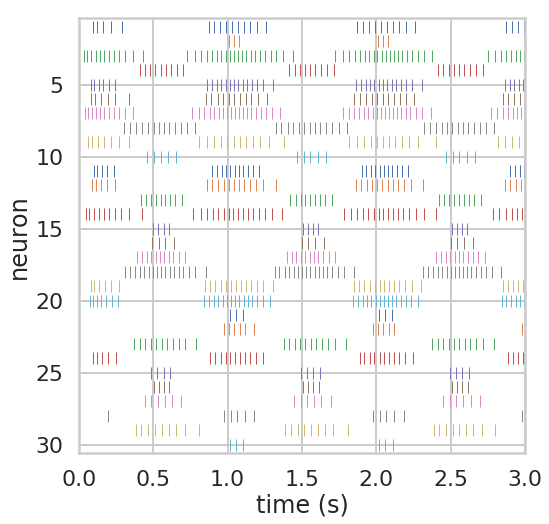

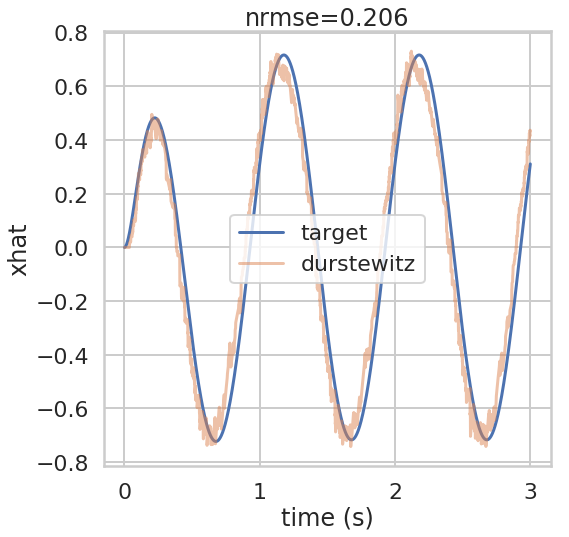

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


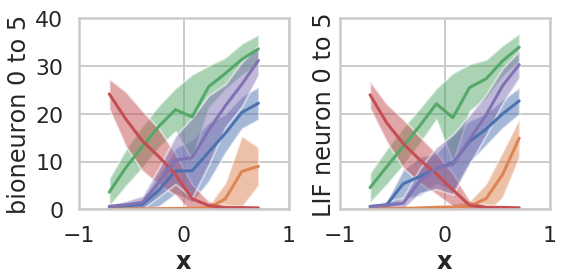

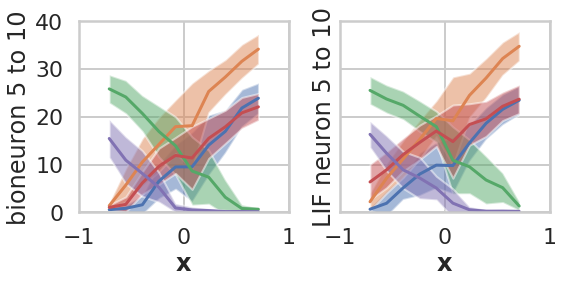

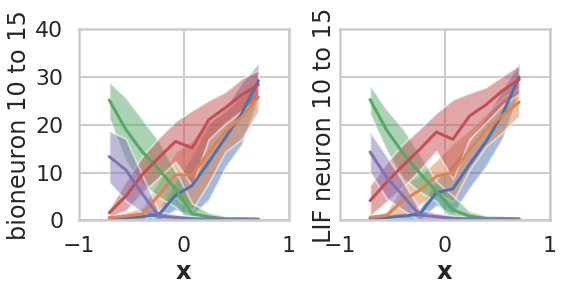

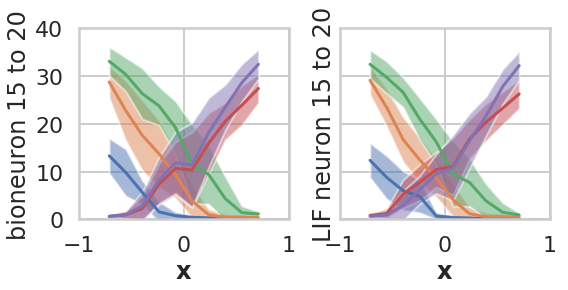

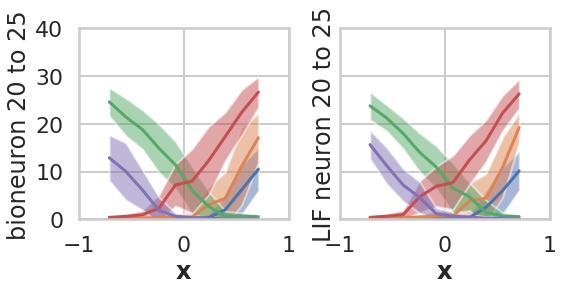

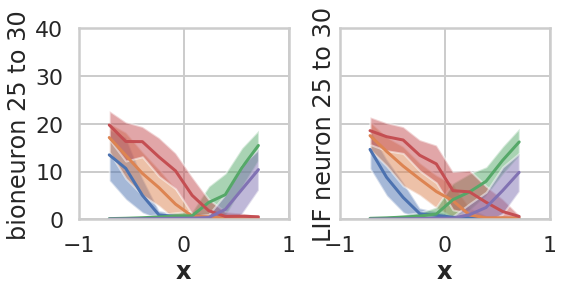

nonzero neurons: 30


In [65]:
reg = 0.1
n_neurons = 30
tau = 0.1
d0 = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(20, 40)
intercepts=Uniform(-0.8, 0.8)
t = 3
dt = 0.001
dt_neuron = 0.025  # ms
freq = 10
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
transform = 1

t0, tar01, s01, v01, tar02, s02, v02, l01, l02 = go(n_neurons, t=t, dt=dt, d=d0,
    max_rates=rates, intercepts=intercepts, transform=transform,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

tar01 = nengo.Lowpass(0.1).filt(tar01)
a01 = nengo.Lowpass(0.1).filt(s01)
al01 = nengo.Lowpass(0.1).filt(l01)
d01 = LstsqL2(reg=reg)(a01, tar01)[0]
xhat01 = np.dot(a01, d01)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, s01)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, tar01, label='target')
ax.plot(t0, xhat01, label='durstewitz', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat', title="nrmse=%.3f" %nrmse(xhat01, target=tar01))
plt.show()

plot_tuning(tar01, a01, al01, rates, neurons_per_plot=5)

print('nonzero neurons:', np.count_nonzero(np.sum(a01, axis=0)))

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

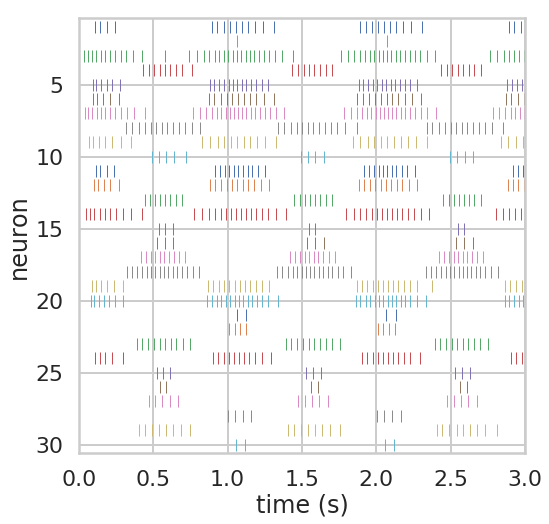

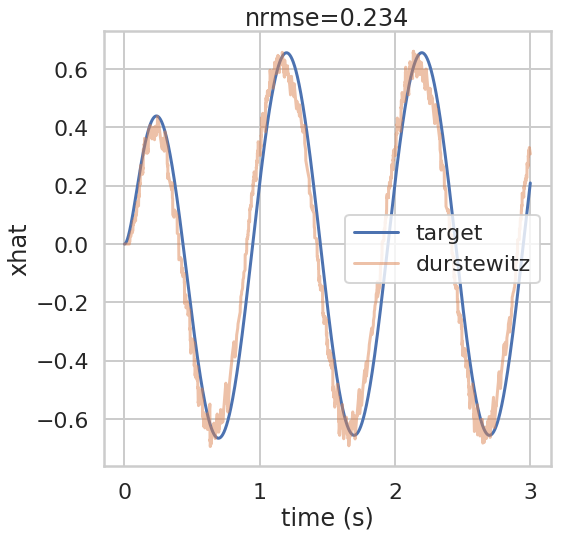

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


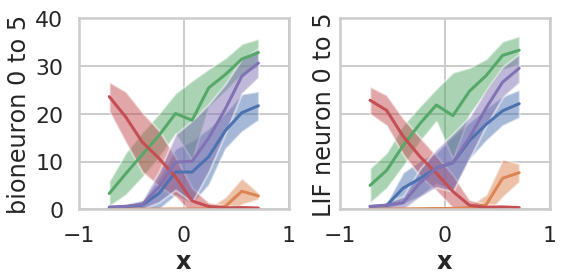

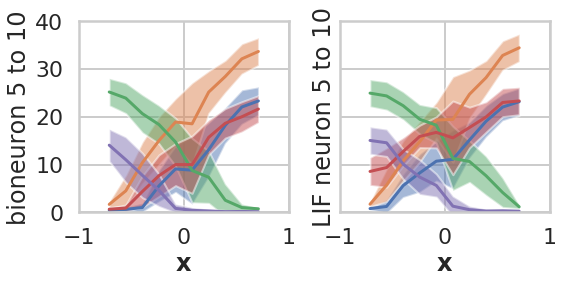

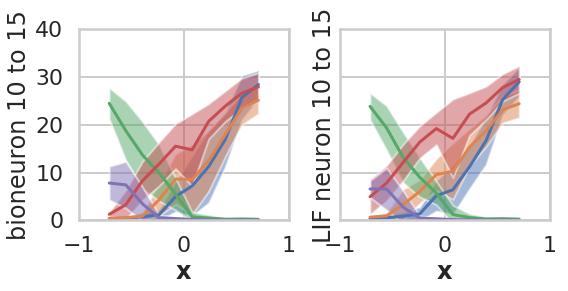

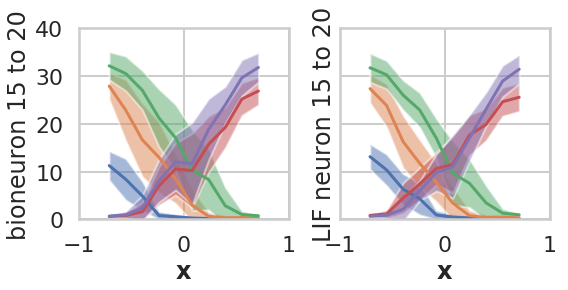

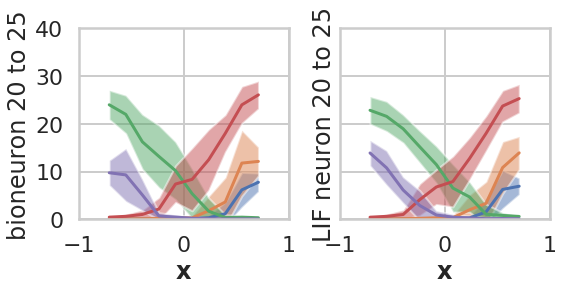

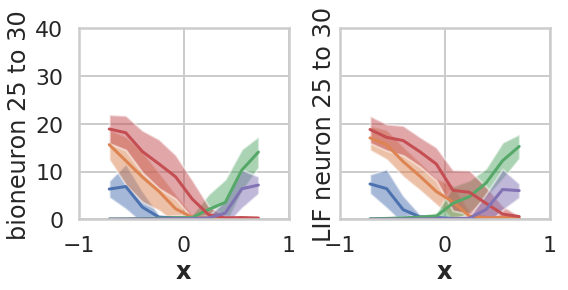

nonzero neurons: 30


In [59]:
reg = 0.1
n_neurons = 30
tau = 0.13
d0 = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(20, 40)
intercepts=Uniform(-0.8, 0.8)
t = 3
dt = 0.001
dt_neuron = 0.025  # ms
freq = 10
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
transform = 1

t0, tar01, s01, v01, tar02, s02, v02, l01, l02 = go(n_neurons, t=t, dt=dt, d=d0,
    max_rates=rates, intercepts=intercepts, transform=transform,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

tar01 = nengo.Lowpass(0.1).filt(tar01)
a01 = nengo.Lowpass(0.1).filt(s01)
al01 = nengo.Lowpass(0.1).filt(l01)
d01 = LstsqL2(reg=reg)(a01, tar01)[0]
xhat01 = np.dot(a01, d01)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, s01)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, tar01, label='target')
ax.plot(t0, xhat01, label='durstewitz', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat', title="nrmse=%.3f" %nrmse(xhat01, target=tar01))
plt.show()

plot_tuning(tar01, a01, al01, rates, neurons_per_plot=5)

print('nonzero neurons:', np.count_nonzero(np.sum(a01, axis=0)))

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

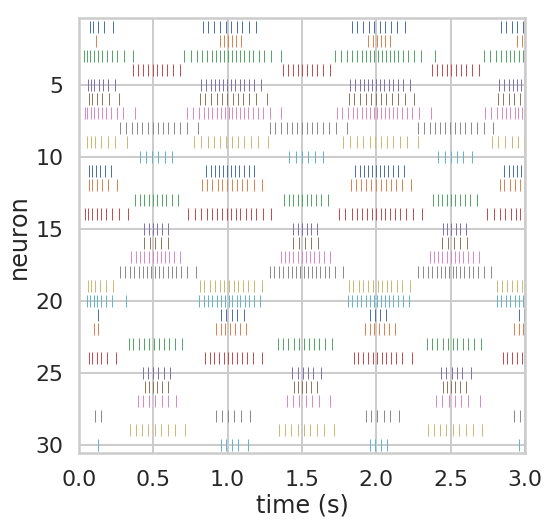

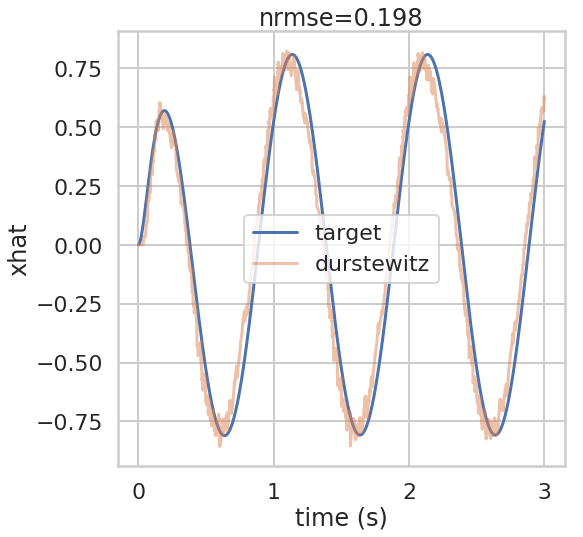

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


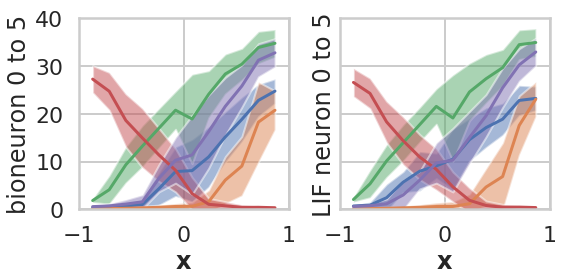

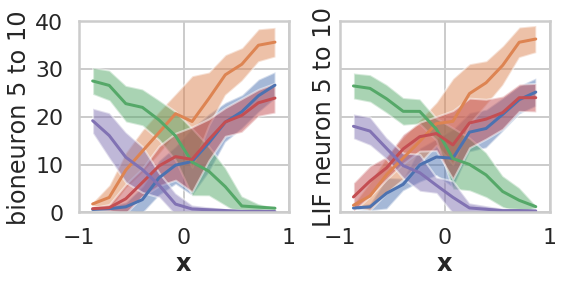

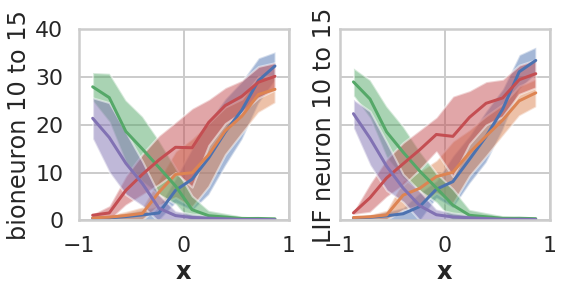

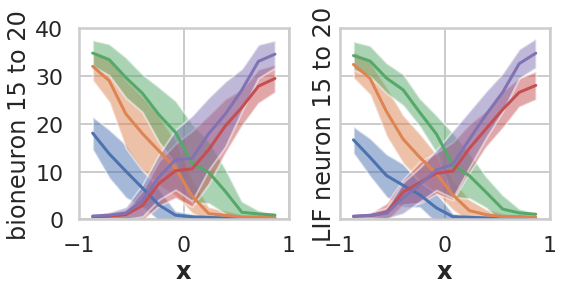

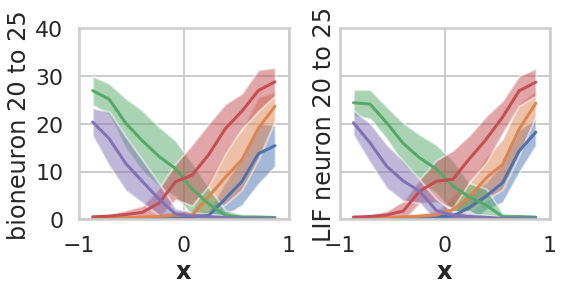

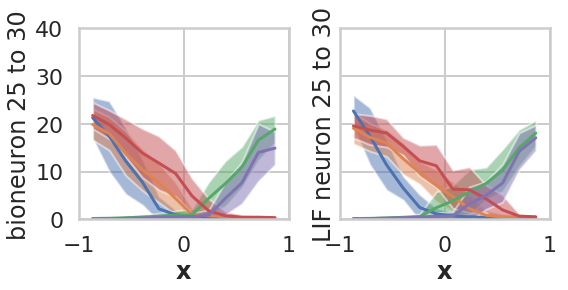

nonzero neurons: 30


In [66]:
reg = 0.1
n_neurons = 30
tau = 0.05
d0 = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(20, 40)
intercepts=Uniform(-0.8, 0.8)
t = 3
dt = 0.001
dt_neuron = 0.025  # ms
freq = 10
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
transform = 1

t0, tar01, s01, v01, tar02, s02, v02, l01, l02 = go(n_neurons, t=t, dt=dt, d=d0,
    max_rates=rates, intercepts=intercepts, transform=transform,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

tar01 = nengo.Lowpass(0.1).filt(tar01)
a01 = nengo.Lowpass(0.1).filt(s01)
al01 = nengo.Lowpass(0.1).filt(l01)
d01 = LstsqL2(reg=reg)(a01, tar01)[0]
xhat01 = np.dot(a01, d01)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, s01)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, tar01, label='target')
ax.plot(t0, xhat01, label='durstewitz', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat', title="nrmse=%.3f" %nrmse(xhat01, target=tar01))
plt.show()

plot_tuning(tar01, a01, al01, rates, neurons_per_plot=5)

print('nonzero neurons:', np.count_nonzero(np.sum(a01, axis=0)))

## bio to bio

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

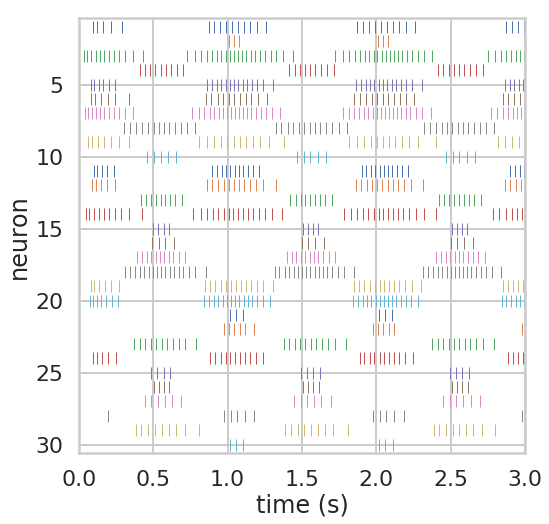

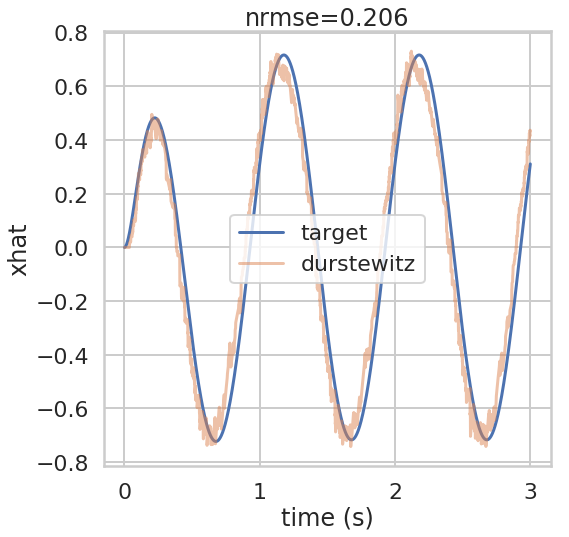

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


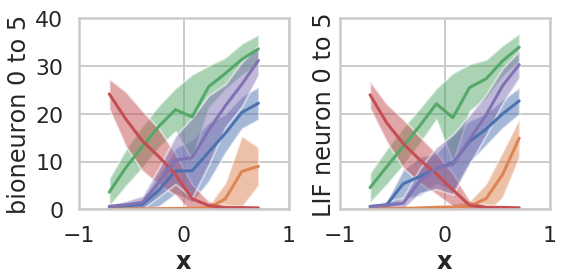

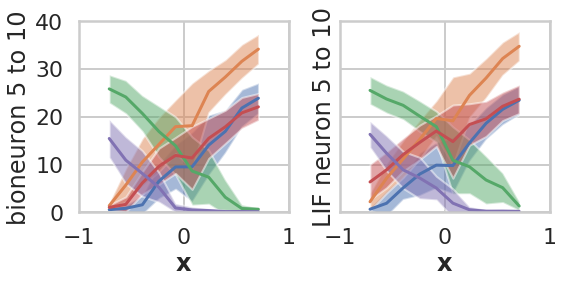

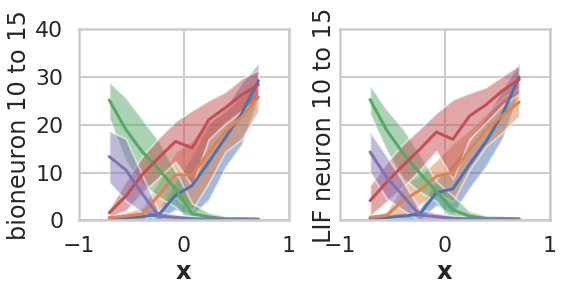

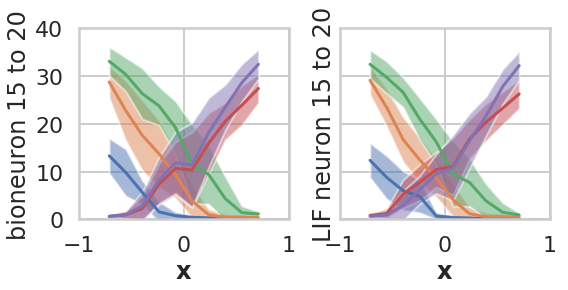

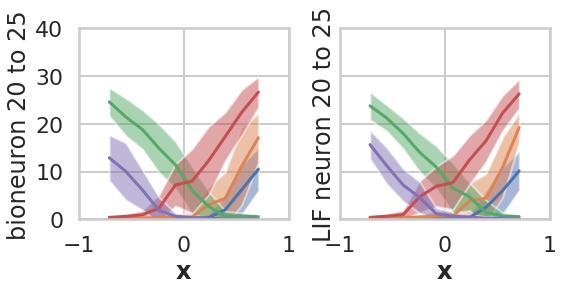

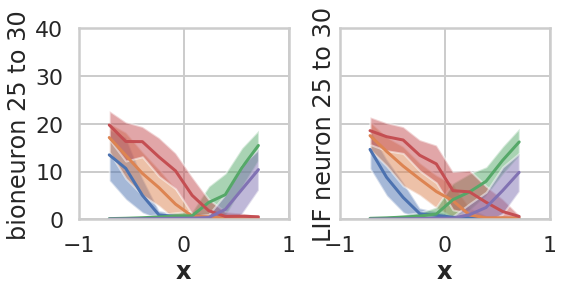

nonzero neurons: 30


In [67]:
reg = 0.1
n_neurons = 30
tau = 0.1
d0 = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(20, 40)
intercepts=Uniform(-0.8, 0.8)
t = 3
dt = 0.001
dt_neuron = 0.025  # ms
freq = 10
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
transform = 1

t0, tar01, s01, v01, tar02, s02, v02, l01, l02 = go(n_neurons, t=t, dt=dt, d=d0,
    max_rates=rates, intercepts=intercepts, transform=transform,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

tar01 = nengo.Lowpass(0.1).filt(tar01)
a01 = nengo.Lowpass(0.1).filt(s01)
al01 = nengo.Lowpass(0.1).filt(l01)
d01 = LstsqL2(reg=reg)(a01, tar01)[0]
xhat01 = np.dot(a01, d01)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, s01)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, tar01, label='target')
ax.plot(t0, xhat01, label='durstewitz', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat', title="nrmse=%.3f" %nrmse(xhat01, target=tar01))
plt.show()

plot_tuning(tar01, a01, al01, rates, neurons_per_plot=5)

print('nonzero neurons:', np.count_nonzero(np.sum(a01, axis=0)))

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

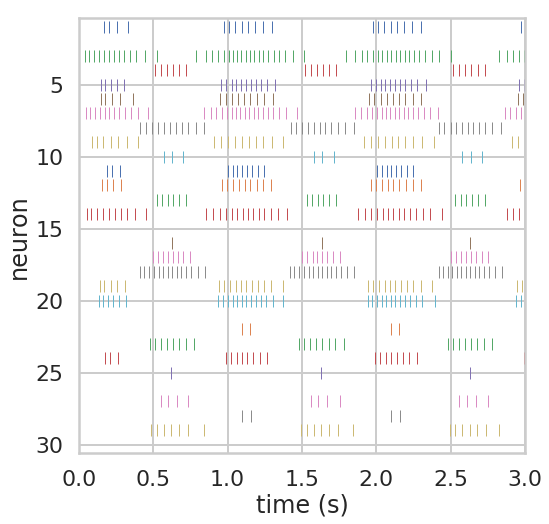

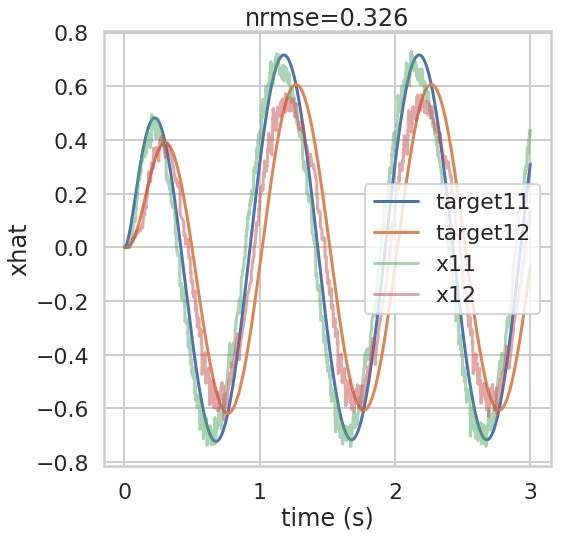

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


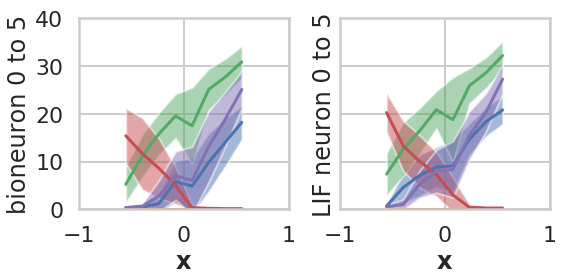

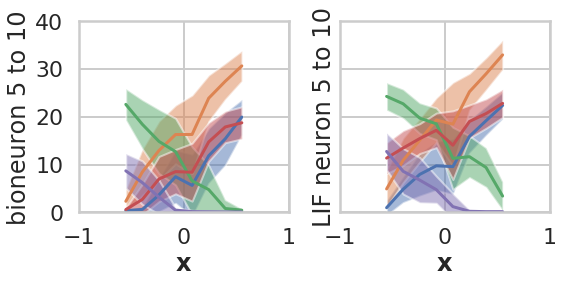

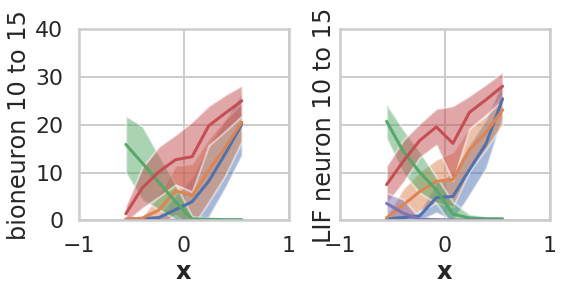

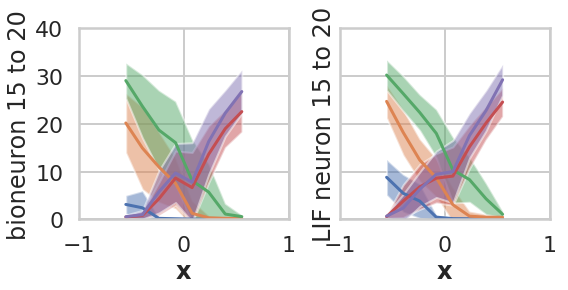

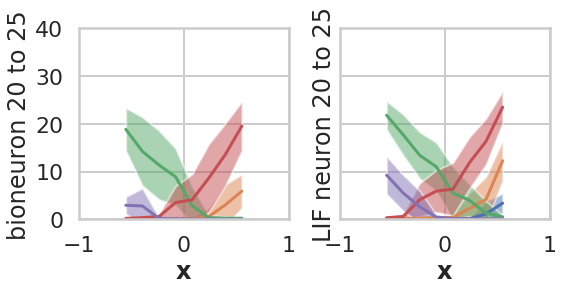

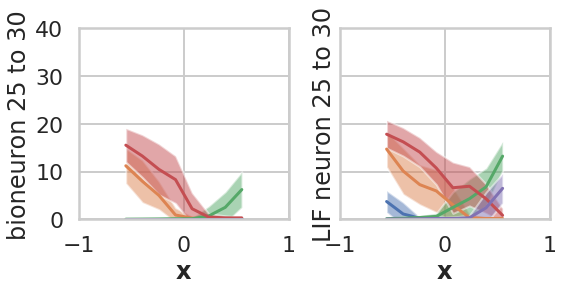

nonzero neurons: 25


In [72]:
t1, tar11, s11, v11, tar12, s12, v12, l11, l12 = go(n_neurons, t=t, dt=dt, d=d01,
    max_rates=rates, intercepts=intercepts, transform=transform,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

tar11 = Lowpass(0.1).filt(tar11)
tar12 = Lowpass(0.1).filt(tar12)
a11 = Lowpass(0.1).filt(s11)
al12 = Lowpass(0.1).filt(l12)
a12 = Lowpass(0.1).filt(s12)
d12 = LstsqL2(reg=reg)(a12, tar12)[0]
xhat11 = np.dot(a11, d01)
xhat12 = np.dot(a12, d12)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t1, s12)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, tar11, label='target11')
ax.plot(t1, tar12, label='target12')
ax.plot(t1, xhat11, label='x11', alpha=0.5)
ax.plot(t1, xhat12, label='x12', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat', title="nrmse=%.3f" %nrmse(xhat12, target=tar12))
plt.show()

plot_tuning(tar12, a12, al12, rates, neurons_per_plot=5)

print('nonzero neurons:', np.count_nonzero(np.sum(a12, axis=0)))

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

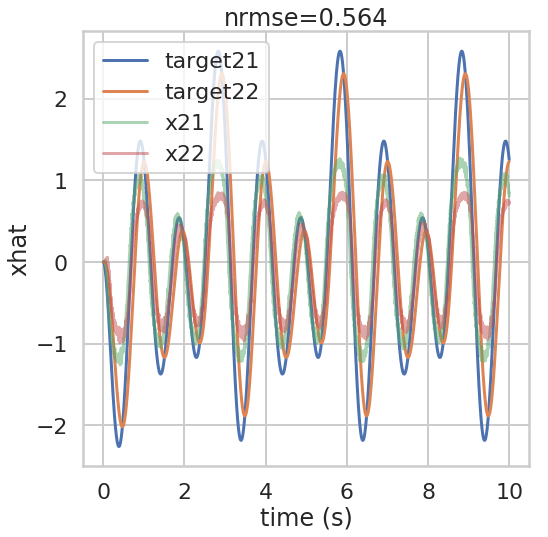

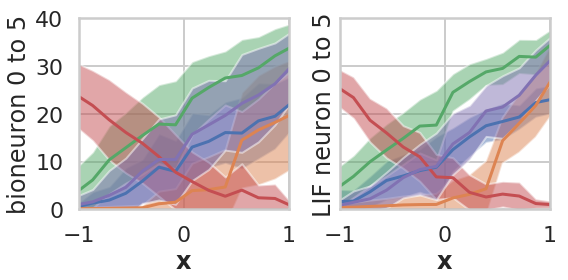

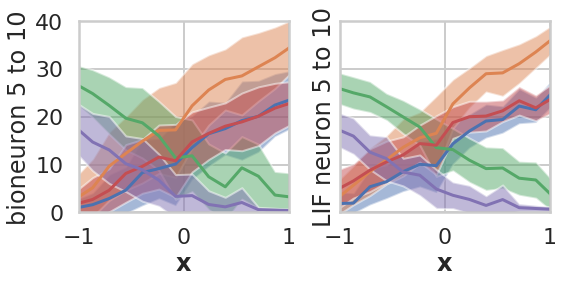

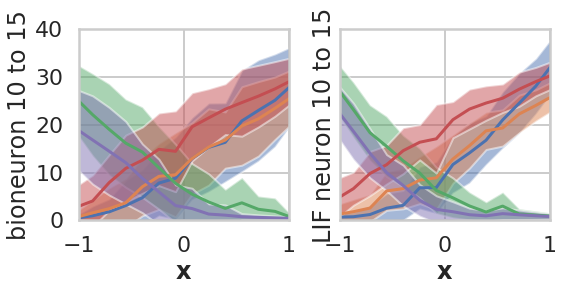

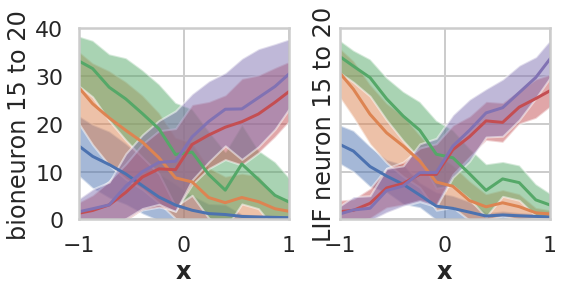

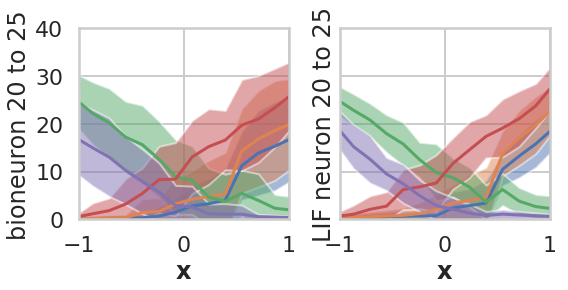

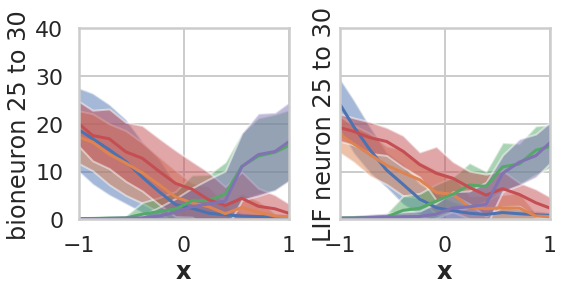

nonzero neurons: 30


In [73]:
t2, tar21, s21, v21, tar22, s22, v22, l21, l22 = go(n_neurons, t=10, dt=dt, d=d01,
    stim_func=nengo.processes.WhiteSignal(period=t, high=1, rms=1.5, seed=0),
    max_rates=rates, intercepts=intercepts, transform=transform,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

tar21 = Lowpass(0.1).filt(tar21)
tar22 = Lowpass(0.1).filt(tar22)
a21 = Lowpass(0.1).filt(s21)
a22 = Lowpass(0.1).filt(s22)
al22 = Lowpass(0.1).filt(l22)
xhat21 = np.dot(a21, d01)
xhat22 = np.dot(a22, d12)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t2, tar21, label='target21')
ax.plot(t2, tar22, label='target22')
ax.plot(t2, xhat21, label='x21', alpha=0.5)
ax.plot(t2, xhat22, label='x22', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat', title="nrmse=%.3f" %nrmse(xhat22, target=tar22))
plt.show()

plot_tuning(tar22, a22, al22, rates, neurons_per_plot=5)

print('nonzero neurons:', np.count_nonzero(np.sum(a22, axis=0)))

40.00318398413372


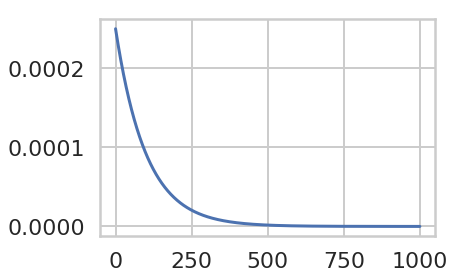

In [27]:
ts = np.arange(0, 1000, 0.025)
tau = 100
ys = 1/tau*np.exp(-ts/tau)
norm = np.sum(ys)
ys /= norm
plt.plot(ts, ys)
print(norm)

39.985591565948894


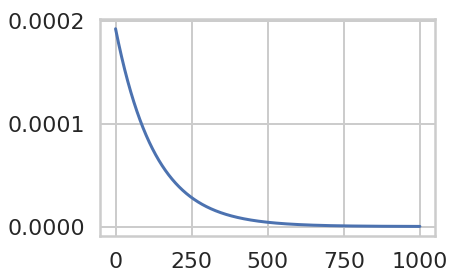

In [28]:
ts = np.arange(0, 1000, 0.025)
tau = 130
ys = 1/tau*np.exp(-ts/tau)
norm = np.sum(ys)
ys /= norm
plt.plot(ts, ys)
print(norm)

1.0


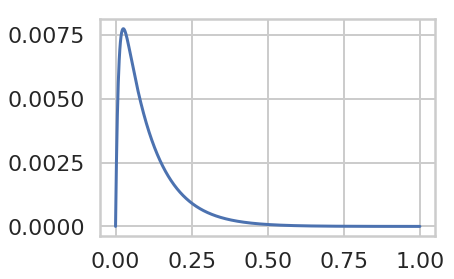

In [97]:
ts = np.arange(0, 1, 0.001)
tau1 = 0.01
tau2 = 0.1
ys = tau2/(tau2-tau1)*(np.exp(-ts/tau1) - np.exp(-ts/tau2))
norm = np.sum(ys)
ys /= norm
plt.plot(ts, ys)
print(np.sum(ys))